In [2]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
import seaborn as sns

from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc import *
from code.fc_cluster import *
from collections import Counter,defaultdict,OrderedDict

from sklearn.preprocessing import scale

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data Frame processing

This file aims to process survey data based on feature contribution matrix and cluster id resulted from kmeans. 

Following data frames are going to be pickled and saved under data directory:

1. Survey data had cluster column added

2. Grouped survey data by cluster id.

3. Numerical survey data goupby cluster id, summarise meaningful answer,reduce redundant features. 



## 1. Load feature contribution matrix and group by cluster id

In [3]:
fc = FeatureContribution('data/fc_df2.pkl')    # Load matrix
fc_df = fc.cluster_processor(3,6)              # Generate cluster id by PCA and Kmeans

To look into each cluster, group data by cluster then aggregate mean and sample size.

In [4]:
summary = fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])  
summary.columns = ['employment_rate','sample_size']
summary

,employment_rate,sample_size
cluster,,
0,0.924484,2132
1,0.082192,365
2,0.040498,642
3,0.900459,653
4,0.895753,259
5,0.059809,418


**Cluster 1,2,5** are unemployed groups. **Cluster 0,3,4** are employed groups. 


## 2.  Load original survey data

In [5]:
sv = survey('data/survey2')
sv.num_processor()

In [6]:
# load suvery data, combine numerical and catigorical anwers
df = pd.concat([sv.fin_data[sv.num_cols],sv.data[sv.sv_cols],sv.fin_data.employed],axis =1) 

# generate a list of 40 important features and cluster id
cols = list(fc.features)
cols.append('cluster')

# subset 40 important features
df = df[fc.features]

#add cluster_id column
df = pd.DataFrame(np.column_stack((df,fc.cluster_id)),columns =cols)
df[sv.num_cols] = df[sv.num_cols].astype('float')

About half respondents did not answer spouse working hours or ideal number of kids. It's not accurate to take mean or median without removing the flag. Thereby, I'll remove respondents who didn't answer these two questions, then take median values. 

Age, agekdbrn and coninc maintain the median values. Educom uses mean because it further split the clusters. 

In [7]:
dfn = df_num(df)

In [8]:
dfn

,sphrs1,chldidel,age,agekdbrn,coninc,educom
cluster,,,,,,
0,42,2.0,36,25,49882.50,12.62
1,40,3.0,31,19,8617.50,10.80
2,50,2.5,35,25,52811.00,12.94
3,40,2.0,33,21,9033.75,12.28
4,40,3.0,34,19,18745.00,10.44
5,40,3.0,34,22,7124.00,12.08


**Categorical variables**

Lots of "Not applicable" in mode answers. Use secondary mode answer instead if "not applicable" shows up.

In [9]:
# categorical columns
cat_cols = list(set(df.columns) - set(sv.num_cols) - set(['cluster']))

In [10]:
# groupby cluster, aggregate answers to take meaningful modes
df_cat = df.groupby('cluster')[cat_cols].agg([mode_answer_cat])
df_cat.columns = cat_cols

In [11]:
df_summary = pd.concat([dfn,df_cat],axis =1)

In [12]:
df_summary.sort('employed').T

/Users/yleng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


cluster,1,2,5,0,3,4
sphrs1,40,50,40,42,40,40
chldidel,3,2.5,3,2,2,3
age,31,35,34,36,33,34
agekdbrn,19,25,22,25,21,19
coninc,8617.5,52811,7124,49882.5,9033.75,18745
educom,10.8,12.94,12.08,12.62,12.28,10.44
affrmact,Oppose pref,Strongly oppose pref,Strongly oppose pref,Strongly oppose pref,Strongly oppose pref,Strongly oppose pref
fechld,Agree,Agree,Agree,Strongly agree,Agree,Strongly agree
helpnot,Agree with both,Agree with both,Agree with both,Agree with both,Agree with both,Agree with both
spanking,Agree,Agree,Agree,Agree,Agree,Agree


### The summaried data frame is generated.  Pickle survey data frame with cluster id and summarized data for future study

In [13]:
with open('data/df_id.pkl','w') as f:
    pickle.dump(df,f)

In [14]:
with open('data/df_summary.pkl','w') as f:
    pickle.dump(df_summary,f)

### Generate a heatmap

To generate a heatmap of survy data. All the categorical features, such as suvery qestions asking opinions must be conveted to numbers. The final version which passed to random forest model will be used in that case. 

In [15]:
# full-processed final matrix is used 
heat_df = sv.fin_data

# 40 important features and cluster id
cols = list(fc.features)
cols.append('cluster')

# subset 40 important features
heat_df = heat_df[fc.features]

#add cluster_id column
heat_df = pd.DataFrame(np.column_stack((heat_df,fc.cluster_id)),columns =cols)

In [16]:
#Same process to treat numrical columns, but need to normalize it 
heat_df_n = pd.DataFrame(scale(df_num(heat_df)),columns=sv.num_cols)

In [17]:
#groupby cluster, then find mode and meaningful answers for each feature
heat_df_cat = heat_df.groupby('cluster')[cat_cols].agg([mode_answer])
heat_df_cat.columns = cat_cols

# datatype = float
heat_df_cat = heat_df_cat.apply(lambda x: x.astype('float'))

In [18]:
#concatenate 
heat_df_sum = pd.concat([heat_df_n,heat_df_cat],axis =1)
# sort by employment status
heat_df_sum.sort_values('employed',inplace=True)

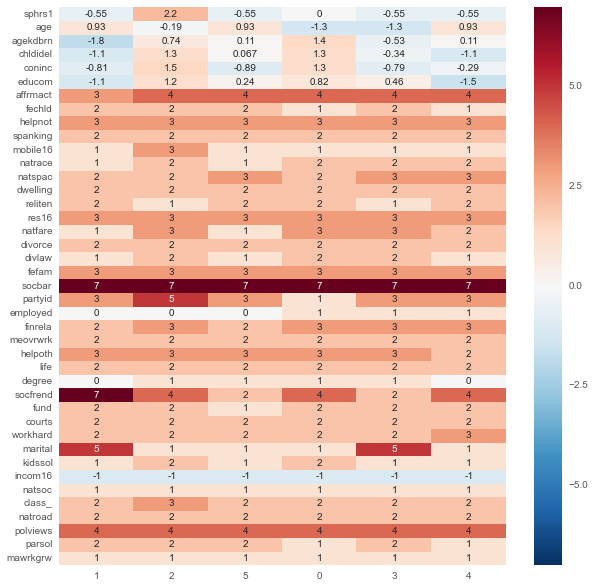

In [23]:
#heat map
plt.figure(figsize=(10,10))
sns.heatmap(heat_df_sum.T,annot=True)

To distinguish clusters, we need to drop the features have the same values across clusters. 

The function, drop_feature, from fc.py is applied to drop redundant features

In [20]:
redu_heat_df = drop_feature(heat_df_sum).T
redu_heat_df = redu_heat_df.reindex(['sphrs1','chldidel','age','agekdbrn','coninc','educom','affrmact',
                                     'fechld','mobile16','natrace','natspac', 'reliten', 'natfare','divlaw',
                                      'partyid', 'finrela', 'helpoth', 'degree','socfrend', 'fund', 'workhard',
                                     'marital', 'kidssol', 'class_', 'parsol','employed'])

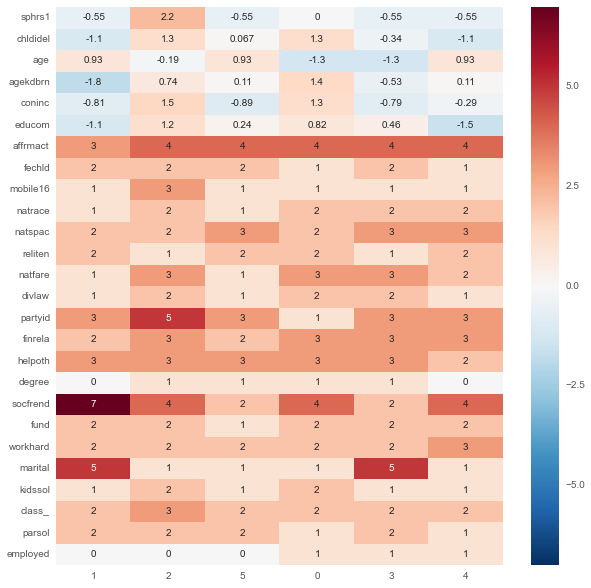

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(redu_heat_df,annot=True)

Now it is easier to check. 
## pickle dimension-reduced data frame, redu_heat_df.

In [22]:
with open('data/redu_heat.pkl','w') as f:
    pickle.dump(redu_heat_df,f)

## To do:

1. write a function to compare the cosine similarities among clusters. Compare the similar cluster, one emp, one unemp. and see what makes them different. 
2. Use data visualization tools to visualize the main decision drivers for each cluster.
